# Data Preparation
### Training a Neural Network to identify the best M3 Combo
By Zach Shelton
5/13/21


In [ ]:
#NanoAOD HackSchema
#Solution from Danny Noonan

In [ ]:
from __future__ import print_function, division
import uproot
import numpy as np
from coffea.nanoevents import NanoAODSchema,NanoEventsFactory
import coffea
from uproot3_methods import TLorentzVectorArray
import uproot3_methods
import numpy as np
import coffea.hist as hist
import matplotlib.pyplot as plt
import awkward1 as ak
class HackSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        base_form["contents"].pop("Electron_photonIdx", None)
        super().__init__(base_form)
files ="TTbarPowheg_Semilept_Skim_NanoAOD_1of21.root"
import coffea.processor as processor
from pprint import pprint
file=uproot.open(files)
from pprint import pprint

## Note: It seems the Jet columns are sorted from greatest p_t to smallest p_t
Feel free to test, but it seems to be my observation, choosing the 1st, 2nd or 3rd jet via index should remove the issue of it being a coffea sorting artifact or procedure

In [ ]:
#Now lets redo with the cuts detailed by CMS Draft Analysis
#https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view
events =NanoEventsFactory.from_root(files,schemaclass=NanoAODSchema,entry_stop=100).events()

In [ ]:
#Condensing_all Lepton_cuts
jets=events.Jet
jetSel = (jets.pt>30) & (abs(jets.eta)<2.4)
tightJet = jets[jetSel]
bJet = tightJet[tightJet.btagDeepFlavB > 0.642]
muons = events.Muon
muonSel = (muons.pt>30) & (abs(muons.eta)<2.4)
tightMuon = muons[muonSel]
ele = events.Electron
eleSel = (ele.pt>35)&(abs(ele.eta)<2.4)
tightEle = ele[eleSel]
eventSel = (((ak.num(tightMuon)==1) | (ak.num(tightEle)==1)) &
            (ak.num(tightJet)>= 3) & (ak.num(bJet)>=1)
           )
final = events[eventSel]

In [ ]:
#G = Global index of particles - Artifact from Coffea/NanoAOD Tools
print(len(final))

In [ ]:
genPart = events.GenPart
tops = genPart[abs(genPart.pdgId)==6]
tops = tops[tops.hasFlags('isLastCopy')]
tDecay = tops.distinctChildren
tDecay = tDecay[tDecay.hasFlags('isLastCopy')]
t_Events=tDecay[abs(tDecay.pdgId)==5]
W = tDecay[abs(tDecay.pdgId)==24]
W = W[W.hasFlags('isLastCopy')]
WDecay = W.distinctChildren
WDecay = WDecay[WDecay.hasFlags('isLastCopy')]
#t_events is the lone bottom, W_events is the -> two jets
W_Events=ak.flatten(WDecay[ak.all(abs(WDecay.pdgId)<=8,axis=-1)],axis=3)
#select the hadronically decaying W
hadW = ak.num(W_Events,axis=2)==2
#select b quarks associated with hadronically decaying W
hadB = t_Events[hadW]
hadB = ak.flatten(hadB,axis=2)
W_quarks = W_Events[hadW]
W_quarks = ak.flatten(W_quarks,axis=2)
qqb = ak.concatenate([hadB,W_quarks],axis=1)
#To start lets filter for only 1 HadronicW
#Filter out qqb events that have mare than 4 jets
qqb = qqb[ak.count(qqb.pdgId,axis=1)<4]
print(qqb)
print(qqb.pdgId)

In [ ]:
ak.count(qqb.pdgId,axis=1)
qqb[0]

In [ ]:
#Process for determining correct jets.
#match Tightjets with nearest.
#Take the sum of the combinations and compare the transverse momenta of them.

In [125]:
combs=ak.combinations(tightJet,3,replacement=False)
argcombs=ak.argcombinations(tightJet,3,replacement=False)
#In order to accomodate the nearest ccombination specific arrangement, using replacement create EVERY permutation of jets
matchjets=qqb.nearest(events.Jet,axis=1)
print(qqb.nearest(events.Jet,axis=1))
print(len(tightJet))
print(len(matchjets))
#We are matching the pt values

[[Jet, Jet, Jet], [Jet, Jet, Jet], [Jet, ... Jet], [Jet, Jet, Jet], [Jet, Jet, Jet]]
100
100


In [37]:
j=matchjets[0][1]
def equal(j1,j2):
    return (j1.pt==j2.pt)&(j1.eta==j2.eta)&(j1.phi==j2.phi)&(j1.mass==j2.mass)&(j1.area==j2.area)
for e in events.Jet[0]:
    print(equal(j,e))

False
False
False
False
True


In [ ]:
#this is a faster and more reliable
def equal(j1,j2):
    return (j1.pt==j2.pt)&(j1.eta==j2.eta)&(j1.phi==j2.phi)&(j1.mass==j2.mass)&(j1.area==j2.area)
print(equal(events.Jet[0][0],events.Jet[0][0]))

In [183]:
import numba as nb
#Finds the arguments of the matching jet in an event
@nb.jit(nopython=True)
def equal(j1,j2):
    #created this to utilize jit and to avoid any unitended errors, these are the nearest function values and should be obtainable
    return (j1.pt==j2.pt)&(j1.eta==j2.eta)&(j1.phi==j2.phi)&(j1.mass==j2.mass)&(j1.area==j2.area)
def find_combo(match,event):
    #print(len(match))
    if len(match)==0:
        return [None,None,None]
    a=ak.ArrayBuilder()
    #Iterates over every event, matches each jet
    #There are jets that are double matched however
    mj1,mj2,mj3=match[0],match[1],match[2]
    c1=None
    c2=None
    c3=None
    holder=ak.ArrayBuilder()
    for n in range(0,len(event)):
        #compares item by item slow but is compiling in Jit
        #Unsure of how to best use vectorize or numba object methods with awkward, consulting tutorial
        if equal(mj1,event[n]):
            c1=n
            #print(c)
        if equal(mj2,event[n]):
            c2=n
            #print(c)
        if equal(mj3,event[n]):
            c3=n
            #print(c)   
    holder.append([c1,c2,c3])
    return ak.sort(ak.flatten(holder))
def create_combo_array(match_array,event_array):
    output=ak.ArrayBuilder()
    counter=0
    for n1 in range(0,len(event_array)):
        output.append(find_combo(match_array[n1],event_array[n1]))
    return output
output=create_combo_array(matchjets,events.Jet)

In [178]:
#creates truth array
a1,a2,a3=ak.unzip(argcombs)
print(len(a1))
ta1=(output[:,0]==a1)
ta2=(output[:,1]==a2)
ta3=(output[:,2]==a3)
val=ta1&ta2&ta3
trutharray=ak.flatten(val)

100


In [179]:
print(len(trutharray))

1042


In [181]:
#these are good combos( no duplicate matched jets and events with ONLY 1 tW decay)
jetcombos=ak.flatten(combs)
jetcombos[trutharray]

<Array [(Jet, Jet, Jet), (, ... Jet, Jet, Jet)] type='48 * (jet, jet, jet)'>

In [85]:
print(len(temp))
argcombs[19

10


<Array [(0, 1, 2), (0, 1, 3, ... 4), (2, 3, 4)] type='10 * (int64, int64, int64)'>

In [185]:
from matplotlib import pyplot as plt 

In [186]:
good_vals=jetcombos[trutharray]
bad_vals=jetcombos[np.invert(trutharray)]

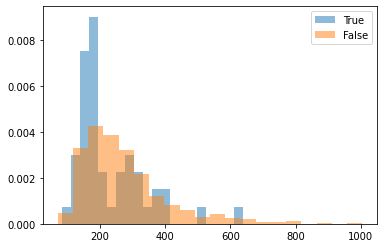

In [188]:
greco=good_vals['0']+good_vals['1']+good_vals['2']
breco=bad_vals['0']+bad_vals['1']+bad_vals['2']
plt.hist(greco.mass,bins=20,alpha=.5,density=True)
plt.hist(breco.mass,bins=20,alpha=.5,density=True)
plt.legend(["True","False"])
plt.show()

______________________________________________________________________________
# Running Notes and questions
- Losing Data because of arbitrary 8 jet cut?

## Notes for Zach to keep up

Wrap into Coffea Executor!!!!!!!!!!!!

Seperate values, weights and triggers(X)
read these into tensors for Keras(X)
Best ML Algorithm?
- Deep Neural Net
- Iterative Boosted Tree
    - They are fast
    - External ML algorithm modifies BDT parameters
- Combine old processes together
Should I use Keras or PyTorch

## Sources/Further Reading:

CMS Draft Analysis Note(FIT, AAS, Wayne State, NISTR): https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view

Invariant Mass Wikipedia Article: https://en.wikipedia.org/wiki/Invariant_mass

Measurement of the semileptonic tt + γ production cross-section in pp collisions at √s = 8 Tev: https://arxiv.org/pdf/1706.08128.pdf

Coffea Documentation: https://coffeateam.github.io/coffea/

Awkward Array Documentation: https://awkward-array.readthedocs.io/en/latest/

AOD DATA GUIDE: https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuideAodDataTable